In [1]:
import os, json, re
import numpy as np
import matplotlib.pyplot as plt
import time

### KONSTRUKCE TRAIN LOSS OBRAZKU

/tmp/ipykernel_1174901/826665596.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


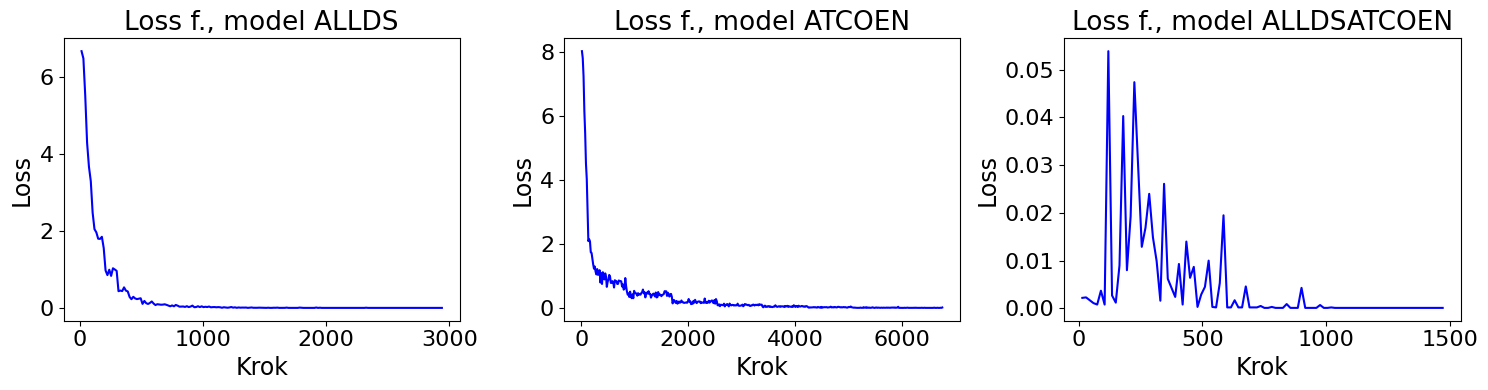

In [ ]:
DIR = './OUT/loss/base'
# files = [os.path.join(DIR,path) if path.endswith('.json') else None for path in os.listdir(DIR)]

dirs = ['verpar-vanmed-atcoen.json',
 'verpar-vanmed-allds.json',
 'mypar-allds-atcoen-full.json'
 ]
HEADINGS = [ 'Loss f., model ALLDS','Loss f., model ATCOEN','Loss f., model ALLDSATCOEN']
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for idx,file in enumerate(dirs):
    # file = os.path.join(PATH, file)
    loaded_file = json.load(open(os.path.join(DIR,file)))
    steps = [entry[1] for entry in loaded_file]
    losses = [entry[2] for entry in loaded_file]
    
    # Plotting
    axs[idx].plot(steps, losses, linestyle='-', color='blue')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    axs[idx].set_title(HEADINGS[idx],fontsize=19)
    axs[idx].set_xlabel("Krok",fontsize=17)
    axs[idx].set_ylabel("Loss", fontsize=17)
    # Adjust tick label font sizes
    axs[idx].tick_params(axis='x', labelsize=16)
    axs[idx].tick_params(axis='y', labelsize=16)
    # axs[idx].set_xticks(fontsize=15)
    # axs[idx].set_yticks(fontsize=15)
    # axs[idx].tight_layout()
    # axs[idx].savefig(os.path.join(DIR, file.replace('.json', '.png')), dpi=300)
    # axs[idx].show()
fig.tight_layout()
fig.savefig(os.path.join(DIR, 'loss.png'), dpi=300)
fig.show()

### KONSTRUKCE TEST WER a LOSS, FULLTS

In [2]:
# number of examples in dataset
# num_examples = {
#     'atco_en_ruzyne': 70,
#     'atco_en_stefanik': 53,
#     'atco_en_zurich': 412,
# }
# lengths = {
#     'atco_en_ruzyne': 718,
#     'atco_en_stefanik': 629,
#     'atco_en_zurich': 2996,
# }

ds_name_list = [
    'atco_en_ruzyne',
    'atco_en_stefanik',
    'atco_en_zurich',
]
def compute_wer_loss(data):
    out = {}
    name=None
    for line in data:
        if ("EVAL MODEL" in line):
            iter_number = re.search(r'(\d)\_iter', line)
            iter_number = iter_number.group(1) if iter_number is not None else '1'
            name=line.strip().split(' ')[-2].split('/')[-1]
            name = iter_number + '_iter_' + name.replace('checkpoint-','') 
            # print(name)
            # print(line)
            out[name]={}
        elif name in out:
            dataset = re.search(r'DATASET: ([a-zA-Z_]+)', line)
            wer = re.search(r'WER: ([\d.]+)', line)
            loss = re.search(r'LOSS: ([\d.]+)', line)
            cal_wer = re.search(r'CALLSIGN WER: ([\d.]+)', line)
            if dataset is None or wer is None and loss is None:
                continue
            out[name][dataset.group(1)]={
                'wer': float(wer.group(1) if wer is not None else 0.0),
                'loss': float(loss.group(1) if loss is not None else 0.0),
            }    
            if cal_wer is not None:
                out[name][dataset.group(1)].update({'cal_wer': float(cal_wer.group(1))})
    return out

def compute_total_wer2(out):
    # total wer
    checkpoints =[]
    wer = {'total':[]}
    cal_wer = {'total':[]}
    loss = {'total':[]}
    for checkpoint,ds_set in out.items():
        checkpoints.append(checkpoint)
        total_wer = 0
        total_loss = 0
        total_cal_wer = 0
        for ds_name,wer_loss in ds_set.items():
            if ds_name not in lengths.keys():
                continue
            if ds_name not in wer:
                wer[ds_name] = []
            if ds_name not in loss:
                loss[ds_name] = []
            if ds_name not in cal_wer:
                cal_wer[ds_name] = []
            wer[ds_name].append(wer_loss['wer'])
            loss[ds_name].append(wer_loss['loss'])
            if 'cal_wer' in wer_loss:
                cal_wer[ds_name].append(wer_loss['cal_wer'])
                total_cal_wer += wer_loss['cal_wer'] * lengths[ds_name]
            total_wer += wer_loss['wer'] * lengths[ds_name]
            total_loss += wer_loss['loss'] * lengths[ds_name]
        # average wer and loss
        wer['total'].append(total_wer / sum(lengths.values()))
        loss['total'].append(total_loss / sum(lengths.values()))
        if 'cal_wer' in wer_loss:
            cal_wer['total'].append(total_cal_wer / sum(lengths.values()))
    return checkpoints, wer, loss, cal_wer

def compute_total_wer(out, total_file):
    # total wer
    checkpoints =[]
    wer = {'total':[]}
    cal_wer = {'total':[]}
    loss = {'total':[]}
    for checkpoint,ds_set in out.items():
        checkpoints.append(checkpoint)
        for ds_name,wer_loss in ds_set.items():
            if ds_name not in ds_name_list:
                continue
            if ds_name not in wer:
                wer[ds_name] = []
            if ds_name not in loss:
                loss[ds_name] = []
            if ds_name not in cal_wer:
                cal_wer[ds_name] = []
            wer[ds_name].append(wer_loss['wer'])
            loss[ds_name].append(wer_loss['loss'])
            if 'cal_wer' in wer_loss:
                cal_wer[ds_name].append(wer_loss['cal_wer'])

    # parse total file
    for line in open(total_file).readlines():
        if ("DATASET: allds |" in line):
            # _dataset = re.search(r'DATASET: ([a-zA-Z_]+)', line)
            _wer = re.search(r'WER: ([\d.]+)', line)
            _loss = re.search(r'LOSS: ([\d.]+)', line)
            _cal_wer = re.search(r'CALLSIGN WER: ([\d.]+)', line)
            # call_count = re.search(r'CALLSIGN COUNT: (\d+)', line)
            # call_correct = re.search(r'CALLSIGN COMPLETELY CORRECT: (\d+)', line)
            
            wer['total'].append(float(_wer.group(1)))
            loss['total'].append(float(_loss.group(1)))
            cal_wer['total'].append(float(_cal_wer.group(1)))
    return checkpoints, wer, loss, cal_wer

In [3]:
def myplot(checkpoints, 
           wer, loss, cal_wer, ax, title='', y_limit_left=None, y_ticks_left=None,y_limit_right=None, y_ticks_right=None,
           plot_total_wer=True, plot_partial_wer=True, 
           plot_total_loss=True, plot_partial_loss=False, 
           plot_total_cal_wer=False, plot_partial_cal_wer=False,
           display_left_axis_label=False, display_right_axis_label=False
    ):
    best={}
    legend_lines = []
    x_arange = np.arange(start=1,stop=len(checkpoints)+1)
    line_width_total = 2
    line_width_partial = 1.5
    # plot WER
    for ds_name in wer:
        best[ds_name] = wer[ds_name][np.argmin(wer['total'])]  
        if ds_name == 'total':
            if plot_total_wer:
                line, = ax.plot(x_arange,wer['total'],linewidth=line_width_total, marker='',color='purple', label='Total WER', zorder=10)
                legend_lines.append([line, 'Total WER'])
            continue
        if plot_partial_wer:
            line, =ax.plot(x_arange,wer[ds_name],linestyle='--',linewidth=line_width_partial, marker='',alpha=0.7, label=ds_name)
            legend_lines.append([line, ds_name])
    
    ax.set_xticks([1,int(0.25*len(checkpoints)),int(0.5*len(checkpoints)),int(0.75*len(checkpoints)),len(checkpoints)])
    ax.set_xlim(0.5, len(checkpoints)+0.5)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    if display_left_axis_label and (plot_total_wer or plot_partial_wer or plot_total_cal_wer or plot_partial_cal_wer):
        ax.set_ylabel('WER %', fontsize=17)
    elif display_left_axis_label and (plot_total_loss or plot_partial_loss):
        ax.set_ylabel('Loss', fontsize=17)
    ax.set_xlabel('Epoch', fontsize=17)
    ax.set_title('Word Error Rate' if title == '' else title,fontsize=19)
    if y_limit_left is not None:
        ax.set_ylim(y_limit_left)
    if y_ticks_left is not None:
        ax.set_yticks(y_ticks_left)
        
    # plot CAL WER
    for ds_name in cal_wer:
        if ds_name == 'total':
            if plot_total_cal_wer:
                line, = ax.plot(x_arange,cal_wer['total'],linewidth=line_width_total, marker='',color='red', label='Total CAL WER', zorder=10)
                legend_lines.append([line, 'Total CAL WER'])
            continue
        if plot_partial_cal_wer:
            line, = ax.plot(x_arange,cal_wer[ds_name],linestyle='--', linewidth=line_width_partial,marker='',alpha=0.7, label=ds_name)
            legend_lines.append([line, ds_name])
            
    # plot loss
    if plot_partial_loss or plot_total_loss:
        if (plot_total_wer or plot_partial_wer or plot_total_cal_wer or plot_partial_cal_wer):
            ax2 = ax.twinx()
            if y_limit_right is not None:
                ax2.set_ylim(y_limit_right)
            if y_ticks_right is not None:
                ax2.set_yticks(y_ticks_right)
        else:
            ax2 = ax
        
        for ds_name in loss:
            if ds_name == 'total':
                if plot_total_loss:
                    line, = ax2.plot(x_arange,loss['total'],linewidth=line_width_total, label='Total Loss')
                    legend_lines.append([line, 'Total Loss'])
                continue
            if plot_partial_loss:
                line, = ax2.plot(x_arange,loss[ds_name],linestyle='--',linewidth=line_width_partial,alpha=0.7, label=ds_name)
                legend_lines.append([line, ds_name])
        
        if display_right_axis_label:
            ax2.set_ylabel('Loss', fontsize=17)
            
        ax2.tick_params(axis='y', labelsize=16)
    return legend_lines

In [4]:
def obtain_diff_zurich_stefanikruzyne(dict_data):
    # Define the weights
    weights = {
        'atco_en_ruzyne': 718,
        'atco_en_stefanik': 629,
        'atco_en_zurich': 2996  # For completeness, though not used for weighting
    }
    combined_lowest_wer_iter = None
    combined_lowest_wer = float('inf')

    total_lowest_wer_iter = None
    total_lowest_wer = float('inf')
    
    zurich_lowest_wer = float('inf')
    zurich_lowest_wer_iter = None
    total_diff = 0
    count = 0

    for idx,(step, data) in enumerate(dict_data.items(),start=1):
        ruzyne_wer = data['atco_en_ruzyne']['wer']
        stefanik_wer = data['atco_en_stefanik']['wer']
        zurich_wer = data['atco_en_zurich']['wer']

        total_wer = ruzyne_wer * weights['atco_en_ruzyne'] + \
            stefanik_wer * weights['atco_en_stefanik'] + \
            zurich_wer * weights['atco_en_zurich']
        total_wer /= sum(weights.values())
        
        if total_wer < total_lowest_wer:
            total_lowest_wer = total_wer
            total_lowest_wer_iter = idx
            
        if zurich_wer < zurich_lowest_wer:
            zurich_lowest_wer = zurich_wer
            zurich_lowest_wer_iter = idx
        
        # Weighted average WER for ruzyne and stefanik
        combined_wer = (
            ruzyne_wer * weights['atco_en_ruzyne'] +
            stefanik_wer * weights['atco_en_stefanik']
        ) / (weights['atco_en_ruzyne'] + weights['atco_en_stefanik'])

        if combined_wer < combined_lowest_wer:
            combined_lowest_wer = combined_wer
            combined_lowest_wer_iter = idx

        # Difference between combined_wer and zurich_wer
        diff = abs(combined_wer - zurich_wer)
        total_diff += diff
        count += 1

    average_diff = total_diff / count if count else None
    # Output the results
    
    print(f"Lowest WER Zurich is {zurich_lowest_wer:.2f} is at {zurich_lowest_wer_iter}")
    print(f"Lowest weighted WER (Ruzyne + Stefanik) is {combined_lowest_wer:.2f} at {combined_lowest_wer_iter}")
    print(f"Average difference between (Ruzyne+Stefanik) and Zurich WER: {average_diff:.2f}")
    print(f"Lowest total WER is {total_lowest_wer:.2f} at {total_lowest_wer_iter}")
    
    return combined_lowest_wer_iter, zurich_lowest_wer_iter, total_lowest_wer_iter

In [5]:
def specialplot(checkpoints, 
           wer, loss, cal_wer, ax, title='', 
           y_limit_left=None, y_ticks_left=None,
           stef_ruzyne_lowwer_iter=None, zurich_lowwer_iter=None, total_lowwer_iter=None
    ):
    best={}
    legend_lines = []
    x_arange = np.arange(start=1,stop=len(checkpoints)+1)
    line_width_total = 4
    line_width_partial = 2.5
    
    # plot WER
    for ds_name in wer:
        best[ds_name] = wer[ds_name][np.argmin(wer['total'])]  
        if ds_name == 'total':
            line, = ax.plot(x_arange,wer['total'],alpha=0.7, linestyle='--',linewidth=line_width_partial, color='purple', label='Total WER', zorder=10)
            legend_lines.append([line, 'Total WER'])
            continue
        line, =ax.plot(x_arange,wer[ds_name],linestyle='--',linewidth=line_width_partial, alpha=0.7, label=ds_name)
        legend_lines.append([line, ds_name])
    
    # plot the vertical lines for the iterations
    if total_lowwer_iter is not None:
        if (total_lowwer_iter == stef_ruzyne_lowwer_iter) and (total_lowwer_iter == zurich_lowwer_iter):
            line = ax.axvline(x=total_lowwer_iter, color='red', ymax=0.33, alpha=0.7, linewidth=line_width_total, label='Total best WER')
        else:
            line = ax.axvline(x=total_lowwer_iter, ymax=1 if total_lowwer_iter not in [zurich_lowwer_iter, stef_ruzyne_lowwer_iter] else 0.5, color='red',alpha=0.7, linewidth=line_width_total,label='Total best WER')
        legend_lines.append([line, 'Total best WER'])
    if stef_ruzyne_lowwer_iter is not None:
        if (total_lowwer_iter == stef_ruzyne_lowwer_iter) and (stef_ruzyne_lowwer_iter == zurich_lowwer_iter):
            line = ax.axvline(x=total_lowwer_iter, color='blue', alpha=0.7, ymin=0.33, ymax=0.66, linewidth=line_width_total, label='Total best WER')
        else:
            line = ax.axvline(x=stef_ruzyne_lowwer_iter, ymin=0 if stef_ruzyne_lowwer_iter != total_lowwer_iter else 0.5, color='blue', alpha=0.7,linewidth=line_width_total, label='Ruzyne+Stefanik')
        legend_lines.append([line, 'Ruzyne+Stefanik best WER'])
    if zurich_lowwer_iter is not None:
        if (zurich_lowwer_iter == stef_ruzyne_lowwer_iter) and (total_lowwer_iter == zurich_lowwer_iter):
            line = ax.axvline(x=total_lowwer_iter, color='green', alpha=0.7, ymin=0.66, linewidth=line_width_total, label='Total best WER')
        else:
            line =ax.axvline(x=zurich_lowwer_iter, ymin=0 if zurich_lowwer_iter != total_lowwer_iter else 0.5, color='green',alpha=0.7, linewidth=line_width_total, label='Zurich')
        legend_lines.append([line, 'Zurich best WER'])
    
    
    x_ticks= sorted(set([1,len(checkpoints)/2,len(checkpoints)]+[stef_ruzyne_lowwer_iter,zurich_lowwer_iter,total_lowwer_iter]))
    if (14 in x_ticks) and (len(checkpoints) > 15):
        x_ticks.remove(15)
        x_ticks.append(16)
        
    ax.set_xticks(x_ticks)
    ax.set_xlim(0.5, len(checkpoints)+0.5)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel('WER %', fontsize=17)
    ax.set_xlabel('Epoch', fontsize=17)
    ax.set_title('Word Error Rate' if title == '' else title,fontsize=19)
    
    if y_limit_left is not None:
        ax.set_ylim(y_limit_left)
    if y_ticks_left is not None:
        ax.set_yticks(y_ticks_left)
        
    # plot CAL WER
    if False:
        for ds_name in wer:
            if ds_name == 'total':
                line, = ax.plot(x_arange,cal_wer['total'],linewidth=1.5, marker='',color='red', label='Total CAL WER', zorder=10)
                legend_lines.append([line, 'Total CAL WER'])
                continue
            line, = ax.plot(x_arange,cal_wer[ds_name],linestyle='--', marker='',alpha=0.7, label=ds_name)
            legend_lines.append([line, ds_name])
            
    # plot loss
    if False:
        ax2 = ax.twinx()
        for ds_name in loss:
            if ds_name == 'total':
                line, = ax2.plot(x_arange,loss['total'],linewidth=1.5, label='Total Loss')
                legend_lines.append([line, 'Total Loss'])
                continue
            line, = ax2.plot(x_arange,loss[ds_name],linestyle='--',alpha=0.7, label=ds_name)
            legend_lines.append([line, ds_name])
        
        ax2.set_ylabel('Loss', fontsize=17)
            
        ax2.tick_params(axis='y', labelsize=16)
    return legend_lines

#### FULLTS

base/fullts/vanmed-allds/vp_eval.txt
Lowest WER Zurich is 21.49 is at 8
Lowest weighted WER (Ruzyne + Stefanik) is 17.29 at 7
Average difference between (Ruzyne+Stefanik) and Zurich WER: 4.54
Lowest total WER is 20.33 at 7

base/fullts/vanmed-atcoen/vp_eval.txt
Lowest WER Zurich is 24.01 is at 6
Lowest weighted WER (Ruzyne + Stefanik) is 18.51 at 12
Average difference between (Ruzyne+Stefanik) and Zurich WER: 6.76
Lowest total WER is 22.42 at 22

base/fullts/allds-atcoen/mp_eval.txt
Lowest WER Zurich is 21.38 is at 8
Lowest weighted WER (Ruzyne + Stefanik) is 17.12 at 6
Average difference between (Ruzyne+Stefanik) and Zurich WER: 3.99
Lowest total WER is 20.18 at 6



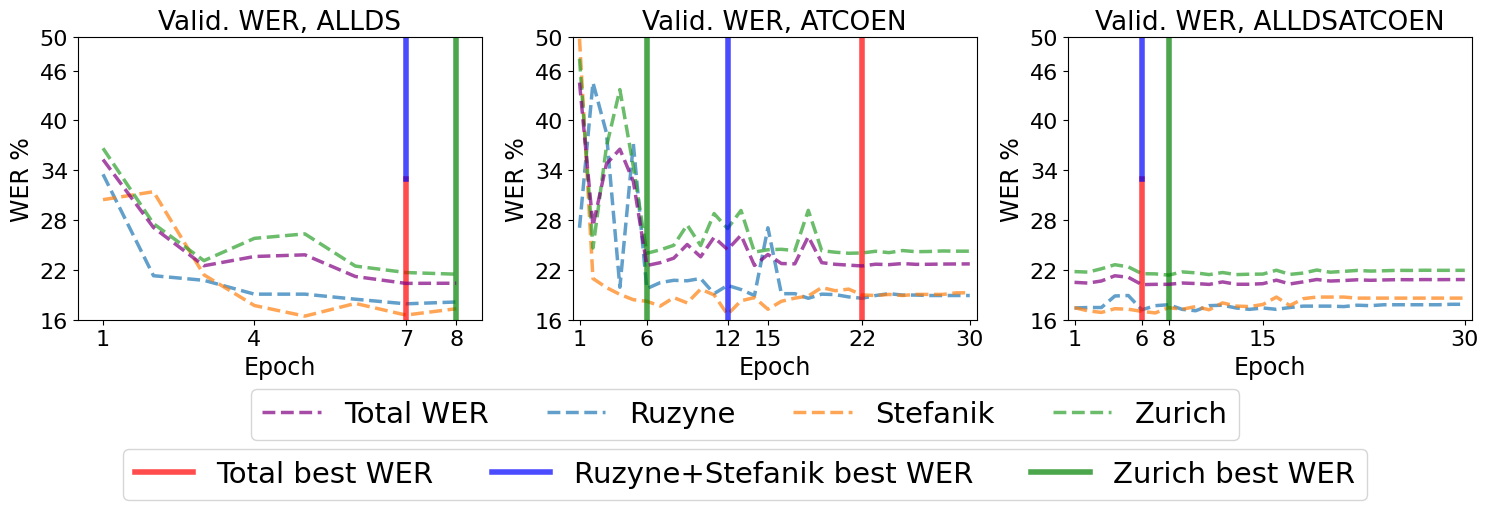

In [ ]:
OUT_DIR = 'OUT/base-full'
DIR=''
dirs = [
    'base/fullts/vanmed-allds/vp_eval.txt',
    'base/fullts/vanmed-atcoen/vp_eval.txt',
    'base/fullts/allds-atcoen/mp_eval.txt',
]
dirs_total = [
    'base/fullts/vanmed-allds/vp_eval_total.txt',
    'base/fullts/vanmed-atcoen/vp_eval_total.txt',
    'base/fullts/allds-atcoen/mp_eval_total.txt',
]
NUM_OF_PLOTS = len(dirs)

TITLES = [ 'Valid. WER, ALLDS', 'Valid. WER, ATCOEN','Valid. WER, ALLDSATCOEN']
FILE_NAME='best_wer_partial_and_total'

# TITLES = [ 'Valid. WER a loss, ALLDS', 'Valid. WER a loss, ATCOEN','Valid. WER a loss, ALLDSATCOEN']
# FILE_NAME = 'wer_loss_total'

# TITLES = [ 'Valid. WER, ALLDS', 'Valid. WER, ATCOEN','Valid. WER, ALLDSATCOEN']
# FILE_NAME = 'wer_partial'

# TITLES = [ 'Valid. loss, ALLDS', 'Valid. loss, ATCOEN','Valid. loss, ALLDSATCOEN']
# FILE_NAME = 'loss_partial'

# TITLES = [ 'Valid. CAL WER, ALLDS', 'Valid. CAL WER, ATCOEN','Valid. CAL WER, ALLDSATCOEN']
# FILE_NAME = 'calwer_partial'

fig, axs = plt.subplots(1, NUM_OF_PLOTS, figsize=(15, 4))

for idx, file in enumerate(dirs):
    data = open(os.path.join(DIR, file))
    out=compute_wer_loss(data)
    checkpoints, wer, loss, cal_wer = compute_total_wer(out,total_file=dirs_total[idx])
    
    if True:
        print(file)
        stef_ruz_lowwer_iter, zurich_lowwer_iter, total_lowwer_iter = obtain_diff_zurich_stefanikruzyne(out)
        legend_lines = specialplot(
            checkpoints, wer, loss, cal_wer, axs[idx],title=TITLES[idx], 
            y_limit_left=[16,50], y_ticks_left=np.arange(16,50,6).tolist() + [50],
            stef_ruzyne_lowwer_iter=stef_ruz_lowwer_iter, zurich_lowwer_iter=zurich_lowwer_iter, total_lowwer_iter=total_lowwer_iter
        )
        print()
    
    if False:
        legend_lines = myplot(
            checkpoints, wer, loss, cal_wer, axs[idx],title=TITLES[idx],
            y_limit_left=[13.5,46], y_ticks_left=np.arange(14,46,5).tolist(),
            # y_limit_left=[15.5,51], y_ticks_left=np.arange(16,51,5).tolist() + [51], # WER
            # y_limit_left=[0.5,1.1], y_ticks_left=np.arange(0.5,1.1,0.1).tolist() + [1.1], # LOSS
            # y_limit_left=[9,30], y_ticks_left= np.arange(9,30,3).tolist() + [30], # CALWER
            y_limit_right=[0.5,1.1], y_ticks_right=np.arange(0.5,1.1,0.1).tolist() + [1.1], # LOSS(+WER)
            plot_total_wer=True, plot_partial_wer=False,
            plot_total_loss=True, plot_partial_loss=False,
            plot_total_cal_wer=True, plot_partial_cal_wer=False,
            display_left_axis_label=True, #if idx == 0 else False,
            display_right_axis_label=True #if idx == NUM_OF_PLOTS-1 else False,
        )

legend_dict = {
    'atco_en_ruzyne': 'Ruzyne',
    'atco_en_stefanik': 'Stefanik',
    'atco_en_zurich': 'Zurich',
}


# fig.legend([leg[0] for leg in legend_lines], [legend_dict[leg[1]] if leg[1] in legend_dict else leg[1] for leg in legend_lines], loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.00),fontsize=19)

# TWO LEGENDS SETUP
fig.legend([leg[0] for leg in legend_lines[:4]], [legend_dict[leg[1]] if leg[1] in legend_dict else leg[1] for leg in legend_lines], loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.05),fontsize=21)
fig.legend([leg[0] for leg in legend_lines[4:]], [legend_dict[leg[1]] if leg[1] in legend_dict else leg[1] for leg in legend_lines[4:]], loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.1),fontsize=21)


fig.tight_layout()
to_add = ''
if (os.path.exists(os.path.join(OUT_DIR, f'{FILE_NAME}.png'))):
    to_add = str(time.time())
# fig.savefig(os.path.join(OUT_DIR, f'{FILE_NAME}{'_'+to_add if to_add else ''}.png'), dpi=300, bbox_inches='tight')

#### SHORTTS

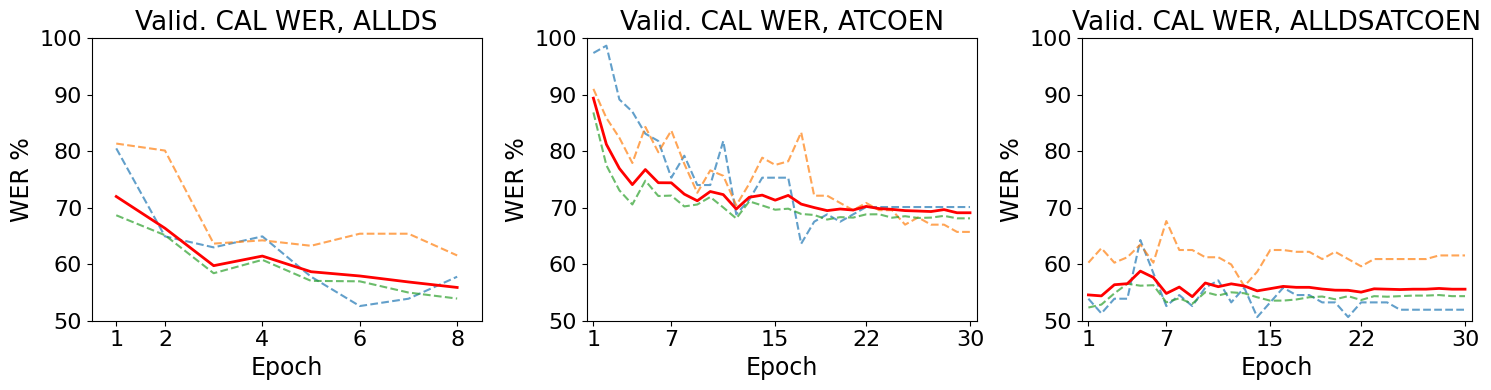

In [59]:
OUT_DIR = 'OUT/base-short'
DIR=''
dirs = [
    'base/shortts/vanmed-allds/vp_eval.txt',
    'base/shortts/vanmed-atcoen/vp_eval.txt',
    'base/shortts/allds-atcoen/mp_eval.txt',
]
dirs_total = [
    'base/shortts/vanmed-allds/vp_eval_total.txt',
    'base/shortts/vanmed-atcoen/vp_eval_total.txt',
    'base/shortts/allds-atcoen/mp_eval_total.txt',
]
NUM_OF_PLOTS = len(dirs)

# TITLES = [ 'Valid. WER, ALLDS', 'Valid. WER, ATCOEN','Valid. WER, ALLDSATCOEN']
# FILE_NAME='best_wer_partial_and_total'

# TITLES = [ 'Valid. WER a loss, ALLDS', 'Valid. WER a loss, ATCOEN','Valid. WER a loss, ALLDSATCOEN']
# FILE_NAME = 'wer_loss_total'

# TITLES = [ 'Valid. WER, ALLDS', 'Valid. WER, ATCOEN','Valid. WER, ALLDSATCOEN']
# FILE_NAME = 'wer_partial'

# TITLES = [ 'Valid. loss, ALLDS', 'Valid. loss, ATCOEN','Valid. loss, ALLDSATCOEN']
# FILE_NAME = 'loss_partial'

TITLES = [ 'Valid. CAL WER, ALLDS', 'Valid. CAL WER, ATCOEN','Valid. CAL WER, ALLDSATCOEN']
FILE_NAME = 'calwer_partial'

fig, axs = plt.subplots(1, NUM_OF_PLOTS, figsize=(15, 4))

for idx, file in enumerate(dirs):
    data = open(os.path.join(DIR, file))
    out=compute_wer_loss(data)
    checkpoints, wer, loss, cal_wer = compute_total_wer(out,total_file=dirs_total[idx])
    
    if False:
        print(file)
        stef_ruz_lowwer_iter, zurich_lowwer_iter, total_lowwer_iter = obtain_diff_zurich_stefanikruzyne(out)
        legend_lines = specialplot(
            checkpoints, wer, loss, cal_wer, axs[idx],title=TITLES[idx], 
            y_limit_left=[26,72], y_ticks_left=np.arange(26,72,7).tolist() + [72],
            stef_ruzyne_lowwer_iter=stef_ruz_lowwer_iter, zurich_lowwer_iter=zurich_lowwer_iter, total_lowwer_iter=total_lowwer_iter
        )
        print()
    
    if True:
        legend_lines = myplot(
            checkpoints, wer, loss, cal_wer, axs[idx],title=TITLES[idx],
            # y_limit_left=[30,93], y_ticks_left=np.arange(30,93,10).tolist(), # WER LOSS
            # y_limit_left=[25,75], y_ticks_left=np.arange(25,75,10).tolist() + [75], # WER
            # y_limit_left=[0.75,1.75], y_ticks_left=np.arange(0.75,1.75,0.15).tolist() + [1.75], # LOSS
            y_limit_left=[50,100], y_ticks_left= np.arange(50,100,10).tolist() + [100], # CALWER
            # y_limit_right=[0.95,1.63], y_ticks_right=np.arange(0.95,1.63,0.1).tolist() + [1.6], # LOSS(+WER)
            plot_total_wer=False, plot_partial_wer=False,
            plot_total_loss=False, plot_partial_loss=False,
            plot_total_cal_wer=True, plot_partial_cal_wer=True,
            display_left_axis_label=True, #if idx == 0 else False,
            display_right_axis_label=False #if idx == NUM_OF_PLOTS-1 else False,
        )

legend_dict = {
    'atco_en_ruzyne': 'Ruzyne',
    'atco_en_stefanik': 'Stefanik',
    'atco_en_zurich': 'Zurich',
}


# fig.legend([leg[0] for leg in legend_lines], [legend_dict[leg[1]] if leg[1] in legend_dict else leg[1] for leg in legend_lines], loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.00),fontsize=19)

# TWO LEGENDS SETUP
# fig.legend([leg[0] for leg in legend_lines[:4]], [legend_dict[leg[1]] if leg[1] in legend_dict else leg[1] for leg in legend_lines], loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.05),fontsize=21)
# fig.legend([leg[0] for leg in legend_lines[4:]], [legend_dict[leg[1]] if leg[1] in legend_dict else leg[1] for leg in legend_lines[4:]], loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.1),fontsize=21)


fig.tight_layout()
to_add = ''
if (os.path.exists(os.path.join(OUT_DIR, f'{FILE_NAME}.png'))):
    to_add = str(time.time())
fig.savefig(os.path.join(OUT_DIR, f'{FILE_NAME}{'_'+to_add if to_add else ''}.png'), dpi=300, bbox_inches='tight')

### PROMPT, FULLTS

In [6]:
def promptplot(checkpoints, 
           wer, loss, cal_wer, ax, title='', 
           y_limit_left=None, y_ticks_left=None,y_limit_right=None, y_ticks_right=None,
           plot_total_wer=True, plot_partial_wer=True, 
           plot_total_loss=True, plot_partial_loss=False, 
           plot_total_cal_wer=False, plot_partial_cal_wer=False,
           display_left_axis_label=False, display_right_axis_label=False
    ):
    best={}
    legend_lines = []
    x_arange = np.arange(start=1,stop=len(checkpoints)+1)
    line_width_total = 2
    line_width_partial = 1.5
    # plot WER
    for ds_name in wer:
        best[ds_name] = wer[ds_name][np.argmin(wer['total'])]  
        if ds_name == 'total':
            if plot_total_wer:
                line, = ax.plot(x_arange,wer['total'],linewidth=line_width_total, marker='', label='AVG WER', zorder=10)
                legend_lines.append([line, 'AVG WER'])
            continue
        if plot_partial_wer:
            line, =ax.plot(x_arange,wer[ds_name],linestyle='--',linewidth=line_width_partial, marker='',alpha=0.7, label=ds_name)
            legend_lines.append([line, ds_name])
    
    ax.set_xticks([1,int(0.25*len(checkpoints)),int(0.5*len(checkpoints)),int(0.75*len(checkpoints)),len(checkpoints)])
    ax.set_xlim(0.5, len(checkpoints)+0.5)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    if display_left_axis_label:
        ax.set_ylabel('WER %', fontsize=17)
    ax.set_xlabel('Epoch', fontsize=17)
    ax.set_title('Word Error Rate' if title == '' else title,fontsize=19)
    
    if y_limit_left is not None:
        ax.set_ylim(y_limit_left)
    if y_ticks_left is not None:
        ax.set_yticks(y_ticks_left)
  
    # plot CAL WER
    for ds_name in cal_wer:
        if ds_name == 'total':
            if plot_total_cal_wer:
                line, = ax.plot(x_arange,cal_wer['total'],linewidth=line_width_total, marker='',color='red', label='Total CAL WER', zorder=10)
                legend_lines.append([line, 'Total CAL WER'])
            continue
        if plot_partial_cal_wer:
            line, = ax.plot(x_arange,cal_wer[ds_name],linestyle='--', linewidth=line_width_partial,marker='',alpha=0.7, label=ds_name)
            legend_lines.append([line, ds_name])
            
    # plot loss
    if False:
        ax2 = ax.twinx()
        ax2.tick_params(axis='y', labelsize=16)
        if display_right_axis_label:
            ax2.set_ylabel('Loss', fontsize=17)
    
        for ds_name in loss:
            if ds_name == 'total':
                if plot_total_loss:
                    line, = ax2.plot(x_arange,loss['total'],linewidth=line_width_total, label='Total Loss')
                    legend_lines.append([line, 'Total Loss'])
                continue
            if plot_partial_loss:
                line, = ax2.plot(x_arange,loss[ds_name],linestyle='--',linewidth=line_width_partial,alpha=0.7, label=ds_name)
                legend_lines.append([line, ds_name])
        
    return legend_lines

AG {'total': [30.67160232681121, 23.356248898290147, 31.94958575709501, 21.57588577472237, 26.705446853516655, 21.293848052176976, 21.98131500088137, 26.855279393618897, 18.1738057465186, 17.997532169927727, 18.82601797990481, 18.447029790234442, 18.226687819495858, 17.733121805041424, 17.75074916270051, 17.962277454609556, 16.939890710382514, 17.31006522122334, 17.609730301427817, 17.627357659086904, 17.627357659086904, 17.530407191961924, 17.61854398025736, 17.733121805041424, 17.662612374405075, 17.72430812621188, 17.689053410893706, 17.697867089723253, 17.671426053234622, 17.671426053234622], 'atco_en_ruzyne': [20.25527192008879, 16.9811320754717, 18.312985571587127, 17.36958934517203, 33.40732519422864, 18.867924528301888, 18.035516093229745, 18.368479467258602, 16.870144284128745, 16.9811320754717, 16.925638179800224, 15.482796892341844, 16.037735849056602, 16.537180910099888, 14.927857935627081, 14.705882352941178, 14.872364039955604, 15.482796892341844, 15.038845726970033, 15.8

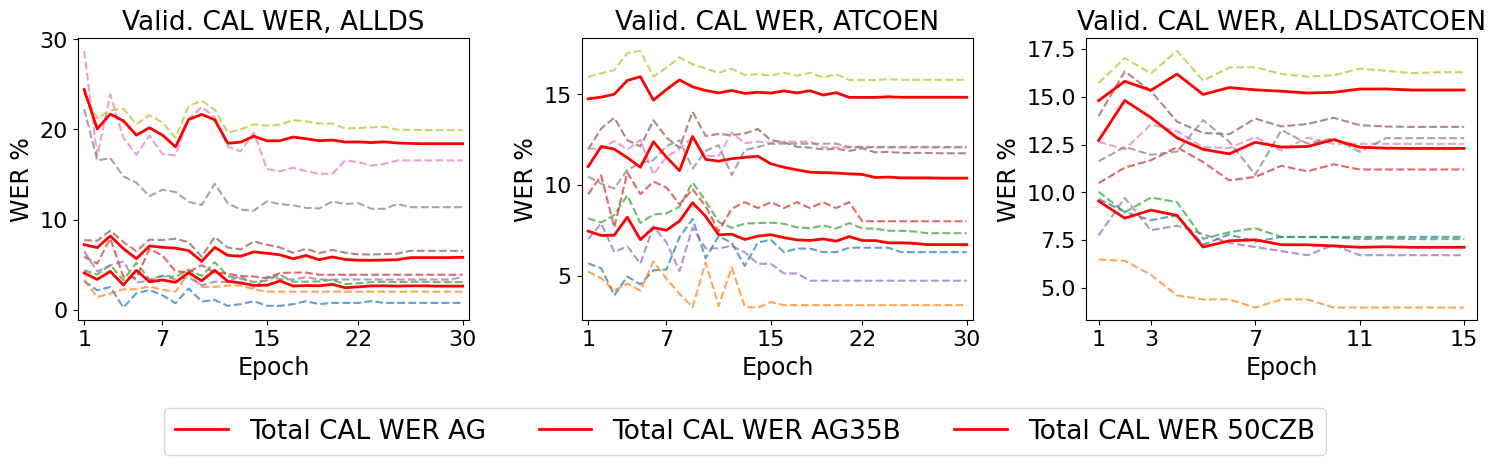

In [ ]:
OUT_DIR = 'OUT/prompt-full'
DIR=''
dirs = [
    'prompt2-wholeds/vanmed-full',
    'prompt2-wholeds/allds-full',
    'prompt2-wholeds/alldsatcoen-full',
]
PROMPTS = ['AG','AG35B','50CZB']

NUM_OF_PLOTS = len(dirs)
# TITLES = [ 'Valid. WER a loss, ALLDS', 'Valid. WER a loss, ATCOEN','Valid. WER a loss, ALLDSATCOEN']
# FILE_NAME = 'wer_loss_total'
# FILE_NAME='best_wer_partial_and_total'

# TITLES = [ 'Valid. WER, P-BASELINE', 'Valid. WER, P-ALLDS','Valid. WER, P-ALLDSATCOEN']
# FILE_NAME = 'wer_avg_AG_AG35B_50CZB'

# TITLES = [ 'Valid. loss, ALLDS', 'Valid. loss, ATCOEN','Valid. loss, ALLDSATCOEN']
# FILE_NAME = 'loss_partial'

# TITLES = [ 'Valid. CAL WER, ALLDS', 'Valid. CAL WER, ATCOEN','Valid. CAL WER, ALLDSATCOEN']
# FILE_NAME = 'calwer_partial'

fig, axs = plt.subplots(1, NUM_OF_PLOTS, figsize=(15, 4))

for idx, dir in enumerate(dirs):
    legend_lines = []
    for prompt_dir in PROMPTS:
        data = open(os.path.join(dir, prompt_dir,'eval.txt'))
        out=compute_wer_loss(data)
        checkpoints, wer, loss, cal_wer = compute_total_wer(out, total_file=os.path.join(dir, prompt_dir,'eval_total.txt'))
        print(prompt_dir,wer)
        legend_lines_ = promptplot(
            checkpoints, wer, loss, cal_wer, axs[idx],title=TITLES[idx],
            y_limit_left=[15,32.5], y_ticks_left=np.arange(15,32.5,2.5).tolist(),
            y_limit_right=None, y_ticks_right=None,
            plot_total_wer=True, plot_partial_wer=False,
            plot_total_loss=False, plot_partial_loss=False,
            plot_total_cal_wer=False, plot_partial_cal_wer=False,
            display_left_axis_label=True, #if idx == 0 else False,
            display_right_axis_label=False #if idx == NUM_OF_PLOTS-1 else False,
        )
        legend_lines += [[legend_lines_[0][0],legend_lines_[0][1] + ' ' + prompt_dir]]

legend_dict = {
    'atco_en_ruzyne': 'Ruzyne',
    'atco_en_stefanik': 'Stefanik',
    'atco_en_zurich': 'Zurich',
}


fig.legend([leg[0] for leg in legend_lines], [legend_dict[leg[1]] if leg[1] in legend_dict else leg[1] for leg in legend_lines], loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.00),fontsize=19)

# TWO LEGENDS SETUP
# fig.legend([leg[0] for leg in legend_lines[:4]], [legend_dict[leg[1]] if leg[1] in legend_dict else leg[1] for leg in legend_lines], loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.05),fontsize=21)
# fig.legend([leg[0] for leg in legend_lines[4:]], [legend_dict[leg[1]] if leg[1] in legend_dict else leg[1] for leg in legend_lines[4:]], loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.1),fontsize=21)


fig.tight_layout()
to_add = ''
if (os.path.exists(os.path.join(OUT_DIR, f'{FILE_NAME}.png'))):
    to_add = str(time.time())
# fig.savefig(os.path.join(OUT_DIR, f'{FILE_NAME}{'_'+to_add if to_add else ''}.png'), dpi=300, bbox_inches='tight')

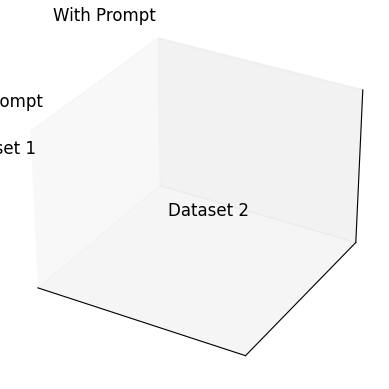

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define datasets and prompt usage
datasets = ['Dataset 1', 'Dataset 2', 'Dataset 3']
prompts = ['Without Prompt', 'With Prompt']

# Create grid for the 3D plot
dataset_vals = [0, 1, 2]
prompt_vals = [0, 1]  # 0 for without prompt, 1 for with prompt

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Remove axis labels and ticks for clarity
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Add labeled lines to mark the dataset and prompt groups
# Place labels slightly above the grid to ensure visibility
for i, dataset in enumerate(datasets):
    # Marking Dataset 1, 2, 3 along the x-axis at a higher z-value for visibility
    ax.text(i, -0.3, 1.1, dataset, color='black', fontsize=12, ha='center', va='center')

for j, prompt in enumerate(prompts):
    # Marking Without Prompt and With Prompt along the y-axis at a higher z-value for visibility
    ax.text(-0.3, j, 1.1, prompt, color='black', fontsize=12, ha='center', va='center')

# Show the plot
plt.show()
